In [1]:
from pyimzml.ImzMLParser import ImzMLParser, browse, getionimage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pytraj as pt
%matplotlib inline

In [2]:
parser = ImzMLParser("/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML")

In [3]:
def tupel2map(spec):
    return dict(zip(spec[0], spec[1])) # m/z -> intensity

In [4]:
def get_peaks(spec):
    #return {key: spec[key] for key in sorted(spec, key=spec.get, reverse=False)[:n]}
    interval = 100#len(spec.keys())//1000
       
    peaks = set()
    
    for intens in pt.tools.n_grams(list(spec.keys()), interval):
        maxI = 0
        maxMZ = 0
        
        epshull = (max(intens)-min(intens))/2
        
        for mz in intens:
            if spec[mz] > maxI:
                maxI = spec[mz]
                maxMZ = mz
        
        tmp = maxMZ
        
        addPeak = True
        if len(peaks) > 0:
            
            #exist already registered peak within epsilon hull with lower intensity?
            for p in peaks:
                
                if abs(p-tmp) < epshull:
                    if spec[p] < spec[tmp]:
                        peaks.remove(p)
                        peaks.add(tmp)
                        addPeak = False
                        break
                    else:
                        
                        addPeak = False
                        break
                        
        if addPeak:
            
            allValues = [spec[mz] for mz in intens]
            if maxI > 5*np.median(allValues):
                peaks.add(tmp)
            
    return np.array(list(peaks))

In [5]:
def get_similarity(spec1, spec2):
    result = [0,0]
    map_1 = tupel2map(parser.getspectrum(spec1))
    map_2 = tupel2map(parser.getspectrum(spec2))
    
    #Similarity (dot product) of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)

    result[0] = cos_lib[0][0]

    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = get_peaks(map_1)
    peaks_spec2 = get_peaks(map_2)
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)
    
    result[1] = cos_lib[0][0]

    return result

In [6]:
def get_distance(spec1, spec2):
    result = [0.0,0.0]
    map_1 = tupel2map(parser.getspectrum(spec1))
    map_2 = tupel2map(parser.getspectrum(spec2))
    
    #Distance between two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[0] = (np.sum(abs(intens1-intens2)))/intens1.shape[0]
    
    #Distance between of two united peak-spectra
    peaks_spec1 = get_peaks(map_1)
    peaks_spec2 = get_peaks(map_2)
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[1] = (np.sum(abs(intens1-intens2)))/intens1.shape[0]
    
    return result

In [7]:
intensities = list()
for x in range(618,  665):
    for y in range(211, 265):
        try:
            idx = parser.coordinates.index((x, y, 1))
            spec_map = tupel2map(parser.getspectrum(idx))
            to_add = list(spec_map.values())
            intensities.extend(to_add)
        except:
            print(f"({x}, {y}, 1) is not in list.")
print(len(intensities))

45430200


In [8]:
pintensities=sorted(intensities)/np.max(intensities)

In [9]:
gpintensities = [x for x in pintensities if x > 0.05]

(array([0.03706616, 0.07285232, 0.10626285, ..., 0.99999458, 0.99999458,
        1.        ]),
 array([0.05000009, 0.05095009, 0.05190009, ..., 0.9981    , 0.99905   ,
        1.        ]),
 <a list of 1 Patch objects>)

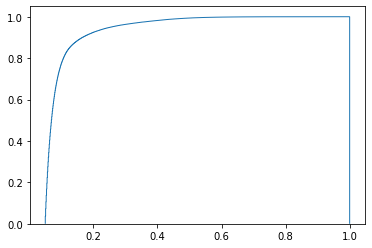

In [10]:
plt.hist(gpintensities,bins=1000,density=True,cumulative=True,histtype='step')

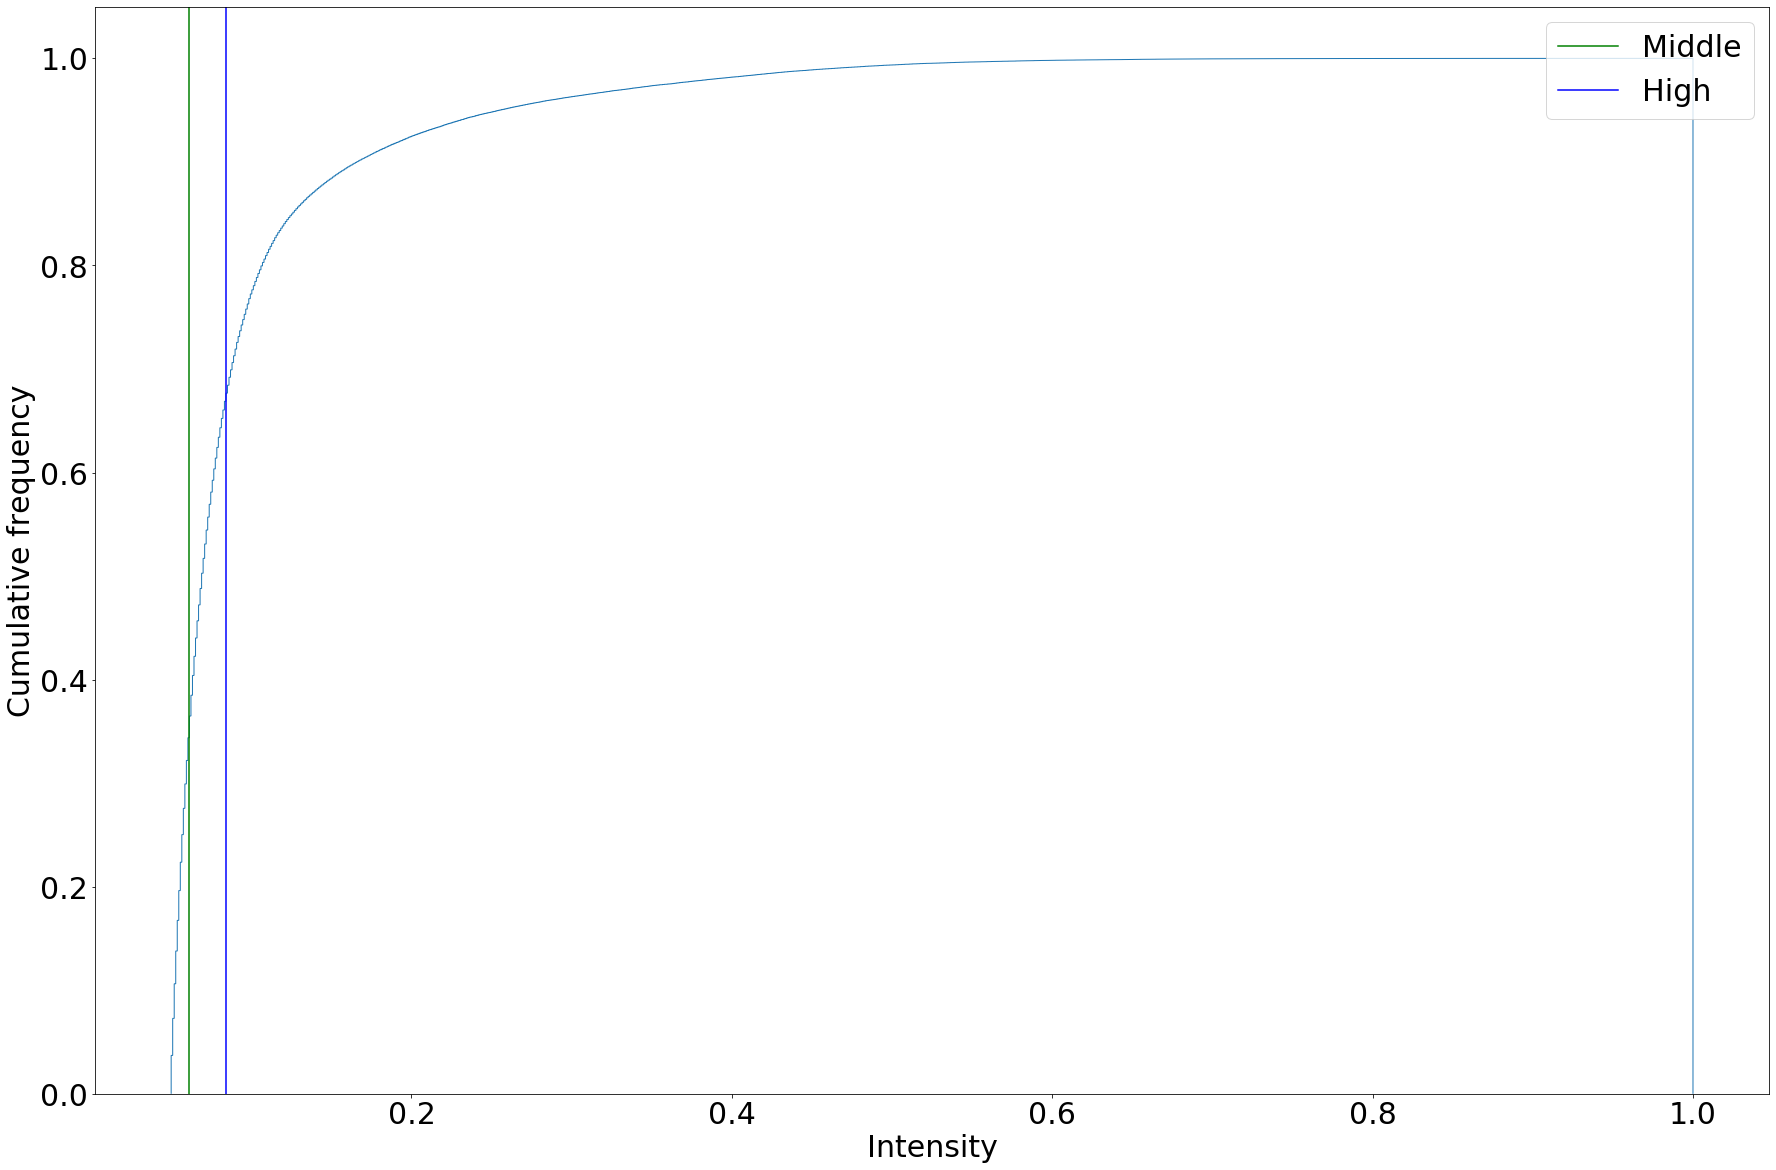

In [11]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1,1,1)
middle = gpintensities[len(gpintensities)//3]
high = gpintensities[2*(len(gpintensities)//3)]
ax.hist(gpintensities,bins=1000,density=True,cumulative=True,histtype='step')
#plt.axvline(x=0.05, c='red')
ax.axvline(x=middle, c='green', label='Middle')
ax.axvline(x=high, c='blue', label='High')
ax.set_xlabel('Intensity', fontsize = 30)
ax.set_ylabel('Cumulative frequency', fontsize = 30)
ax.tick_params(labelsize=30)
ax.legend(fontsize = 30)
plt.savefig('plots/cumsum_freq_intens.png')

In [12]:
middle

0.06094517784716186

In [13]:
high

0.08394087860919387

In [14]:
interval_matrix = [[1, 0.75, 0.1, 0],
                   [0.75, 1, 0.75, 0.1],
                   [0.1, 0.75, 1, 0.75],
                   [0, 0.1, 0.75, 1]]

In [15]:
def get_intes_region(intens):
    if intens < 0.05:
        return 0
    if intens > 0.05 and intens < middle:
        return 1
    if intens > middle and intens < high:
        return 2
    if intens > high:
        return 3

In [16]:
def compare_intens(intens1, intens2):
    intens1 = get_intes_region(intens1)
    intens2 = get_intes_region(intens2)
    return interval_matrix[intens1][intens2]

In [17]:
compare_intens(0.001, 0.0001)

1

In [18]:
def get_matrix_similarity(spec1, spec2):
    result = [0,0]
    map_1 = tupel2map(parser.getspectrum(spec1))
    map_2 = tupel2map(parser.getspectrum(spec2))
    
    #Similarity of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)

    result[0] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)
    
    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = get_peaks(map_1)
    peaks_spec2 = get_peaks(map_2)
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[1] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)

    return result

In [19]:
get_matrix_similarity(10000,19)

[0.9293156424581006, 0.5967213114754099]

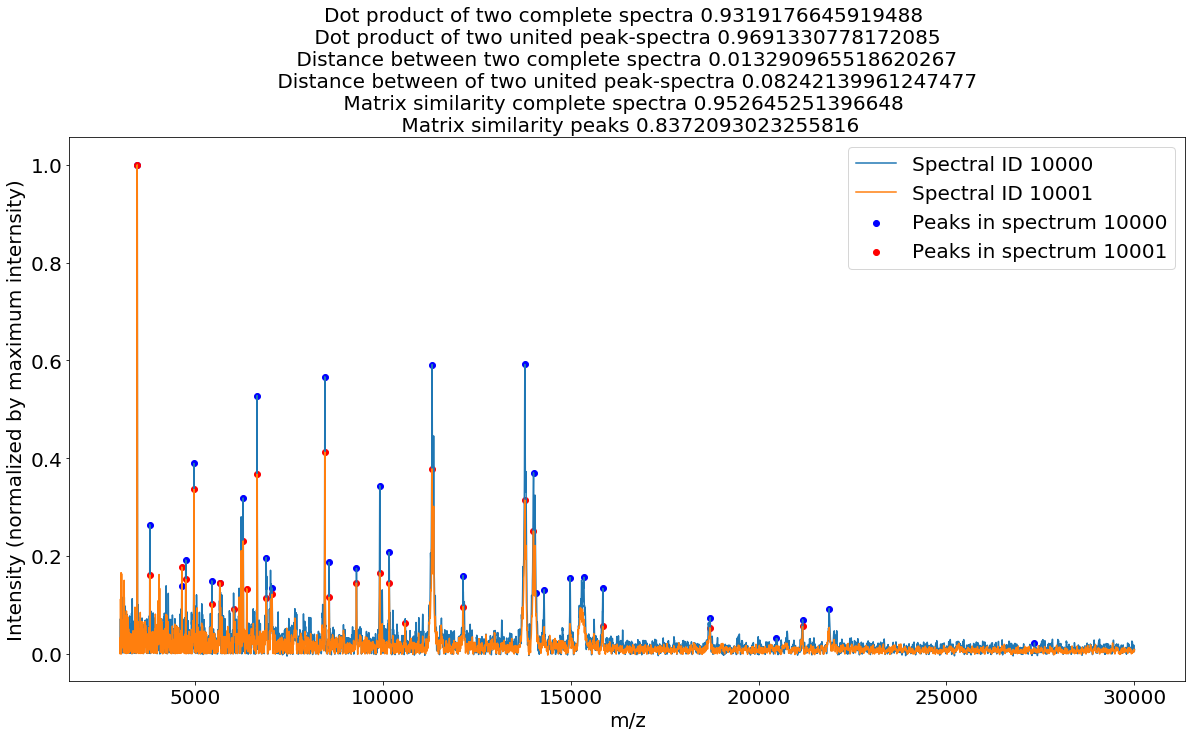

In [22]:
id1 = 10000
id2 = 10001
mapid1 = tupel2map(parser.getspectrum(id1))
mapid2 = tupel2map(parser.getspectrum(id2))
peaksid1 = get_peaks(mapid1)
peaksid2 = get_peaks(mapid2)

plt.figure(figsize=(20,10))

lists = mapid1.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x,y/max(y), label="Spectral ID {}".format(id1))
values = [mapid1[x] for x in peaksid1]
plt.scatter(list(peaksid1), values/max(y), c='blue', label='Peaks in spectrum {}'.format(id1))


lists = mapid2.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x,y/max(y), label="Spectral ID {}".format(id2))
values = [mapid2[x] for x in peaksid2]
plt.scatter(list(peaksid2), values/max(y), c='red', label='Peaks in spectrum {}'.format(id2))

similarity = get_similarity(id1, id2)
distance = get_distance(id1, id2)
matrix_sim = get_matrix_similarity(id1, id2)
plt.title("Dot product of two complete spectra {} \n Dot product of two united peak-spectra {} \n Distance between two complete spectra {} \n Distance between of two united peak-spectra {} \n Matrix similarity complete spectra {}  \n Matrix similarity peaks {}".format(similarity[0], similarity[1], distance[0], distance[1], matrix_sim[0], matrix_sim[1]), fontsize=20)
plt.xlabel("m/z", fontsize=20)
plt.ylabel("Intensity (normalized by maximum internsity)", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('plots/PA_2.png')

In [ ]:
pixel_map = dict()
for x in range(617,  665):
    for y in range(210, 265):
        try:
            idx = parser.coordinates.index((x, y, 1))
            spec_map = tupel2map(parser.getspectrum(idx))
            pixel_map[idx] = (spec_map, get_peaks(spec_map))
        except:
            print(f"({x}, {y}, 1) is not in list.")

(625, 218, 1) is not in list.
(625, 225, 1) is not in list.
(625, 226, 1) is not in list.
(625, 227, 1) is not in list.
(625, 228, 1) is not in list.
(625, 229, 1) is not in list.
(625, 230, 1) is not in list.
(625, 231, 1) is not in list.
(625, 232, 1) is not in list.
(625, 233, 1) is not in list.
(625, 234, 1) is not in list.
(625, 235, 1) is not in list.
(625, 237, 1) is not in list.
(625, 238, 1) is not in list.
(625, 239, 1) is not in list.
(627, 237, 1) is not in list.
(627, 238, 1) is not in list.
(627, 239, 1) is not in list.
(627, 240, 1) is not in list.
(627, 241, 1) is not in list.
(627, 242, 1) is not in list.
(627, 243, 1) is not in list.
(627, 244, 1) is not in list.
(627, 245, 1) is not in list.
(627, 246, 1) is not in list.
(627, 247, 1) is not in list.
(627, 248, 1) is not in list.
(627, 249, 1) is not in list.
(627, 250, 1) is not in list.
(627, 251, 1) is not in list.
(627, 252, 1) is not in list.
(627, 253, 1) is not in list.
(627, 254, 1) is not in list.
(627, 255,

In [31]:
def get_similarity2(spec1, spec2, id_map):
    result = [0,0]
    map_1 = id_map[spec1][0]
    map_2 = id_map[spec2][0]
    
    #Similarity (dot product) of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)

    result[0] = cos_lib[0][0]

    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = id_map[spec1][1]
    peaks_spec2 = id_map[spec2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)
    
    result[1] = cos_lib[0][0]

    return result

def get_distance2(spec1, spec2, id_map):
    result = [0.0,0.0]
    map_1 = id_map[spec1][0]
    map_2 = id_map[spec2][0]
    
    #Distance between two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[0] = (np.sum(abs(intens1-intens2)))/intens1.shape[0]
    
    #Distance between of two united peak-spectra
    peaks_spec1 = id_map[spec1][1]
    peaks_spec2 = id_map[spec2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[1] = (np.sum(abs(intens1-intens2)))/intens1.shape[0]
    
    return result

def get_matrix_similarity2(spec1, spec2, id_map):
    result = [0,0]
    map_1 = id_map[spec1][0]
    map_2 = id_map[spec2][0]
    
    #Similarity of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)

    result[0] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)
    
    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = id_map[spec1][1]
    peaks_spec2 = id_map[spec2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[1] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)

    return result

In [22]:
pixel_map = dict()
for x in range(617,  665):
    for y in range(210, 265):
        try:
            idx = parser.coordinates.index((x, y, 1))
            spec_map = tupel2map(parser.getspectrum(idx))
            pixel_map[idx] = (spec_map, get_peaks(spec_map))
        except:
            print(f"({x}, {y}, 1) is not in list.")
            
ids = list(pixel_map.keys())

dot_product = np.zeros((len(ids), len(ids)))
similarity = np.zeros((len(ids), len(ids)))
matrix_similarity = np.zeros((len(ids), len(ids)))

for i in range(len(ids)):
    for j in range(i, len(ids)):
        tmp = get_similarity2(ids[i], ids[j], pixel_map)
        dot_product[i, j] = dot_product[j, i] = tmp
        tmp2 = get_distance2(ids[i], ids[j], pixel_map)
        similarity[i, j] = similarity[j, i] = 1-tmp2
        tmp3 = get_matrix_similarity2(ids[i], ids[j], pixel_map)
        matrix_similarity[i, j] = matrix_similarity[j, i] = tmp3

(617, 210, 1) is not in list.
(617, 211, 1) is not in list.
(617, 212, 1) is not in list.
(617, 213, 1) is not in list.
(617, 214, 1) is not in list.
(617, 215, 1) is not in list.
(617, 216, 1) is not in list.
(617, 217, 1) is not in list.
(617, 218, 1) is not in list.
(617, 219, 1) is not in list.
(617, 220, 1) is not in list.
(617, 221, 1) is not in list.
(617, 222, 1) is not in list.
(617, 223, 1) is not in list.
(617, 224, 1) is not in list.
(617, 225, 1) is not in list.
(617, 226, 1) is not in list.
(617, 227, 1) is not in list.
(617, 228, 1) is not in list.
(617, 229, 1) is not in list.
(617, 230, 1) is not in list.
(617, 231, 1) is not in list.
(617, 232, 1) is not in list.
(617, 233, 1) is not in list.
(617, 234, 1) is not in list.
(617, 235, 1) is not in list.
(617, 236, 1) is not in list.
(617, 237, 1) is not in list.
(617, 238, 1) is not in list.
(617, 239, 1) is not in list.
(617, 240, 1) is not in list.
(617, 241, 1) is not in list.
(617, 242, 1) is not in list.
(617, 243,

ValueError: setting an array element with a sequence.

In [30]:
dot_product == np.zeros((len(ids), len(ids)))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [32]:
ids = list(pixel_map.keys())

dot_product_all = np.zeros((len(ids), len(ids)))
dot_product_peaks = np.zeros((len(ids), len(ids)))
similarity_all = np.zeros((len(ids), len(ids)))
similarity_peaks = np.zeros((len(ids), len(ids)))
matrix_similarity_all = np.zeros((len(ids), len(ids)))
matrix_similarity_peaks = np.zeros((len(ids), len(ids)))

for i in range(len(ids)):
    for j in range(i, len(ids)):
        tmp = get_similarity2(ids[i], ids[j], pixel_map)
        dot_product_all[i, j] = dot_product_all[j, i] = tmp[0]
        dot_product_peaks[i, j] = dot_product_peaks[j, i] = tmp[1]
        tmp2 = get_distance2(ids[i], ids[j], pixel_map)
        similarity_all[i, j] = similarity_all[j, i] = 1-tmp2[0]
        similarity_peaks[i, j] = similarity_peaks[j, i] = 1-tmp2[1]
        tmp3 = get_matrix_similarity2(ids[i], ids[j], pixel_map)
        matrix_similarity_all[i, j] = matrix_similarity_all[j, i] = tmp3[0]
        matrix_similarity_peaks[i, j] = matrix_similarity_peaks[j, i] = tmp3[0]

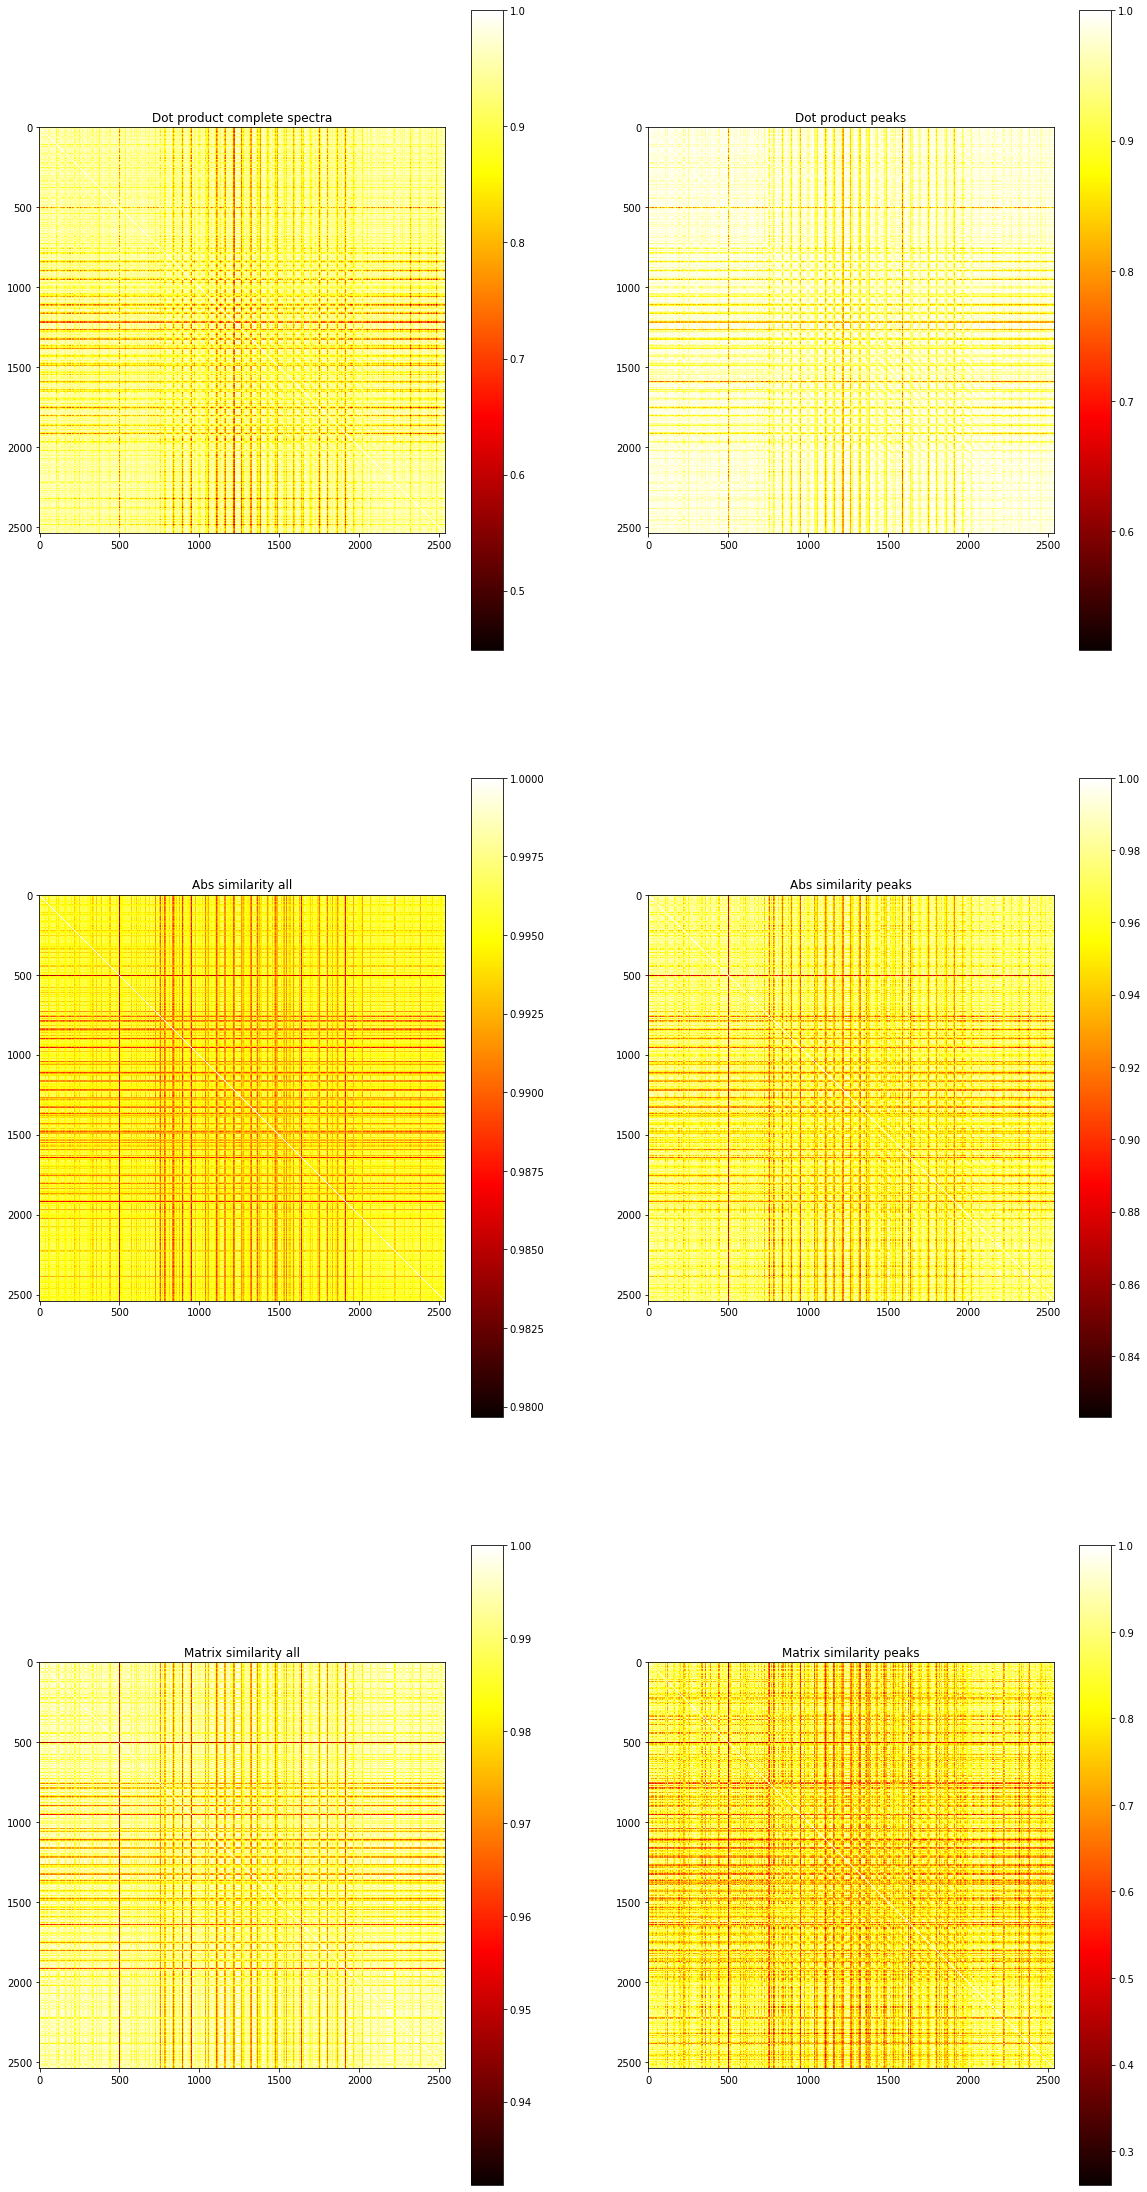

In [53]:
fig = plt.figure(figsize=(20, 40))
fig.add_subplot(3,2,1)
plt.imshow(dot_product_all, cmap='hot', interpolation='nearest')
plt.title('Dot product complete spectra')
plt.colorbar()
fig.add_subplot(3,2,2)
plt.imshow(dot_product_peaks, cmap='hot', interpolation='nearest')
plt.title('Dot product peaks')
plt.colorbar()
fig.add_subplot(3,2,3)
plt.imshow(similarity_all, cmap='hot', interpolation='nearest')
plt.title('Abs similarity all')
plt.colorbar()
fig.add_subplot(3,2,4)
plt.imshow(similarity_peaks, cmap='hot', interpolation='nearest')
plt.title('Abs similarity peaks')
plt.colorbar()
fig.add_subplot(3,2,5)
plt.imshow(matrix_similarity_all, cmap='hot', interpolation='nearest')
plt.title('Matrix similarity all')
plt.colorbar()
fig.add_subplot(3,2,6)
plt.imshow(matrix_similarity_peaks, cmap='hot', interpolation='nearest')
plt.title('Matrix similarity peaks')
plt.colorbar()
plt.savefig('sim_methods_hist.png')

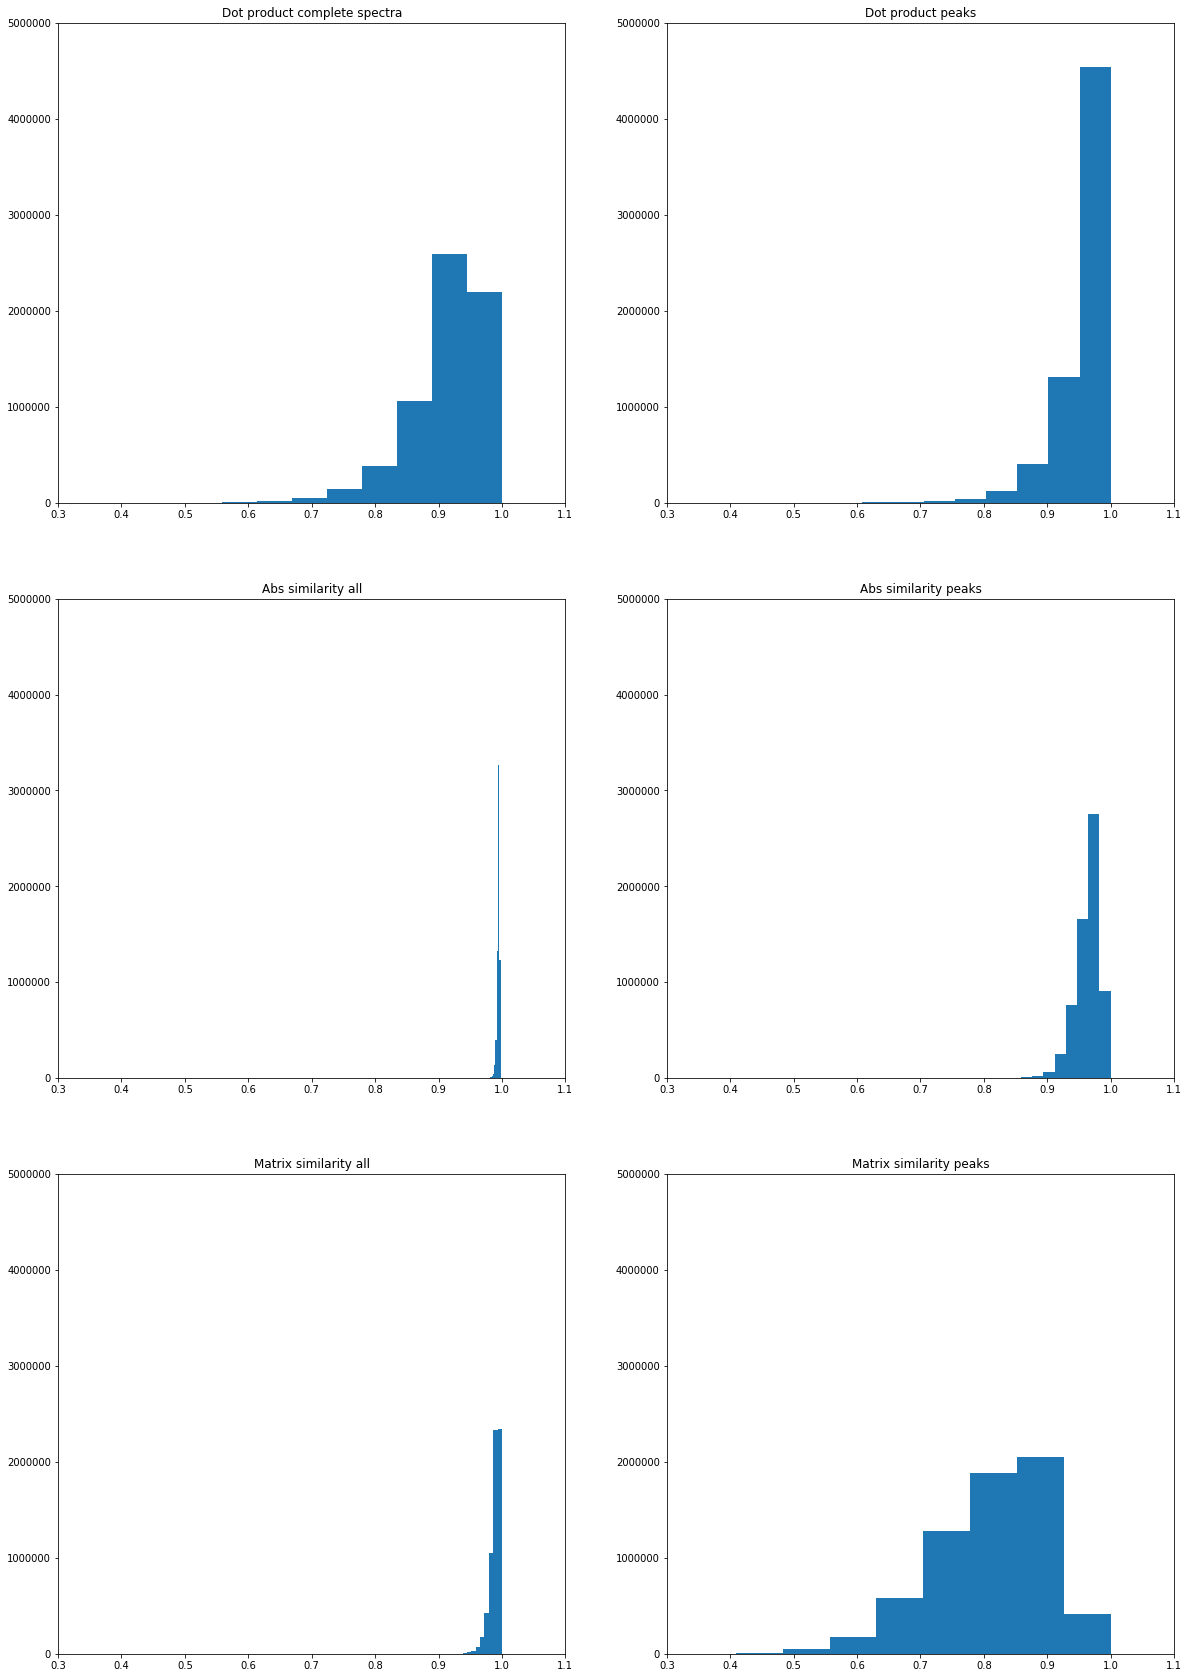

In [77]:
fig = plt.figure(figsize=(20, 30))
ax1 = fig.add_subplot(3,2,1)
ax1.set_ylim((0, 5000000)) 
ax1.set_xlim((0.3, 1.1)) 
ax1.hist(re_dot_product_all)
ax1.title.set_text('Dot product complete spectra')
ax2 = fig.add_subplot(3,2,2)
ax2.set_ylim((0, 5000000)) 
ax2.set_xlim((0.3, 1.1)) 
ax2.hist(re_dot_product_peaks)
ax2.title.set_text('Dot product peaks')
ax3 = fig.add_subplot(3,2,3)
ax3.set_ylim((0, 5000000)) 
ax3.set_xlim((0.3, 1.1))
ax3.hist(re_similarity_all)
ax3.title.set_text('Abs similarity all')
ax4 = fig.add_subplot(3,2,4)
ax4.set_ylim((0, 5000000)) 
ax4.set_xlim((0.3, 1.1))
ax4.hist(re_similarity_peaks)
ax4.title.set_text('Abs similarity peaks')
ax5 = fig.add_subplot(3,2,5)
ax5.set_ylim((0, 5000000)) 
ax5.set_xlim((0.3, 1.1))
ax5.hist(re_matrix_similarity_all)
ax5.title.set_text('Matrix similarity all')
ax6 = fig.add_subplot(3,2,6)
ax6.set_ylim((0, 5000000)) 
ax6.set_xlim((0.3, 1.1))
ax6.hist(re_matrix_similarity_peaks)
ax6.title.set_text('Matrix similarity peaks')
plt.savefig('sim_methods_dist.png')

In [57]:
re_dot_product_all = dot_product_all.reshape(dot_product_all.size,)
re_dot_product_peaks = dot_product_peaks.reshape(dot_product_peaks.size,)
re_similarity_all = similarity_all.reshape(similarity_all.size,)
re_similarity_peaks = similarity_peaks.reshape(similarity_peaks.size,)
re_matrix_similarity_all = matrix_similarity_all.reshape(matrix_similarity_all.size,)
re_matrix_similarity_peaks = matrix_similarity_peaks.reshape(matrix_similarity_peaks.size,)

In [56]:
re_dot_product_all.shape

(6441444,)

In [78]:
#Markus
def nested_item(depth, value):
    if depth <= 1:
        return [value]
    else:
        return [nested_item(depth - 1, value)]


def nested_list(n):
    """Generate a nested list where the i'th item is at depth i."""
    lis = []
    for i in range(n):
        if i == 0:
            lis.append(i)
        else:
            lis.append(nested_item(i, i))
    return lis


def flatten(lis):
    """Given a list, possibly nested to any level, return it flattened."""
    new_lis = []
    for item in lis:
        if type(item) in [list, tuple]:
            new_lis.extend(flatten(item))
        else:
            new_lis.append(item)
    return new_lis


class MatrixClust:

    def __init__(self, M, labels):
        self.matrix = M
        self.labels = labels

    def cluster(self, mode='UPGMA'):

        nLabels = [x for x in self.labels]
        nMatrix = {}
        origMatrix = {}

        for i in range(0, len(self.matrix)):

            for j in range(0, len(self.matrix[i])):
                nMatrix[((nLabels[i],), (nLabels[j],))] = self.matrix[i][j]
                nMatrix[((nLabels[j],), (nLabels[i],))] = self.matrix[i][j]

        for x in nMatrix:
            origMatrix[x] = nMatrix[x]

        treeLabel = ""

        endClusters = 1

        if mode == "NEIGHBOR":
            endClusters = 2

        while len(self.matrixLabels(nMatrix)) > endClusters:

            # find lowest element positions

            clustA = None
            clustB = None

            nLabels = sorted(list(self.matrixLabels(nMatrix)), key=lambda x: str(x))
            #print(nLabels)
            #print(self.to_matrix(nMatrix, nLabels))

            if mode == "NEIGHBOR":

                allLabels = self.matrixLabels(nMatrix)
                aElems = [x for x in nMatrix.items()]

                r_iMap = {}

                # calculate r_i
                for label in allLabels:
                    labelElems = [x for x in aElems if x[0][0] == label or x[0][1] == label]
                    labelsSum = sum([x[1] for x in labelElems]) / 2.0
                    r_iMap[label] = labelsSum

                mijMat = {}

                for elem in aElems:
                    lLabel = elem[0][0]
                    rLabel = elem[0][1]

                    mijMat[(lLabel, rLabel)] = elem[1] - ((r_iMap[lLabel] + r_iMap[rLabel]) / (len(allLabels) - 2))

                #print(r_iMap)
                #print(mijMat)
                mijLabels = sorted(self.matrixLabels(mijMat), key=lambda x: str(x))
                #print("mij", mijLabels)
                #print("mij", self.to_matrix(mijMat, mijLabels))

                sElems = sorted([x for x in mijMat.items()], key=lambda x: x[1])

                minElem = sElems[0]
                clustA = minElem[0][0]
                clustB = minElem[0][1]

            else:
                sElems = sorted([x for x in nMatrix.items()], key=lambda x: x[1])
                minElem = sElems[0]

                clustA = minElem[0][0]
                clustB = minElem[0][1]

            #print("Merging", clustA, clustB)

            if clustA == None or clustB == None:
                exit(-1)

            sElems = sorted([x for x in nMatrix.items()], key=lambda x: x[1])

            # merge clusters
            newCluster = tuple(sorted(flatten(clustA) + flatten(clustB)))

            # copy unchanged elems
            newElems = []
            otherLabels = set()

            for elem in sElems:

                cLabels = elem[0]

                lLabelMerging = cLabels[0] in [clustA, clustB]
                rLabelMerging = cLabels[1] in [clustA, clustB]

                if lLabelMerging and rLabelMerging:
                    continue
                elif lLabelMerging:
                    otherLabels.add(cLabels[1])
                    continue
                elif rLabelMerging:
                    otherLabels.add(cLabels[0])
                    continue

                newElems.append(elem)

            newCluster = (clustA, clustB)

            if len(otherLabels) == 0:
                break

            # calculate new distances
            for label in otherLabels:

                dist = 0

                label = tuple(label)

                distA = self.matrixDistance(nMatrix, clustA, label)
                distB = self.matrixDistance(nMatrix, clustB, label)

                if mode == 'UPGMA':

                    dist += len(clustA) * distA
                    dist += len(clustB) * distB

                    dist = dist / (len(clustA) + len(clustB))

                elif mode == 'SINGLE':

                    dist = min([distA, distB])


                elif mode == 'COMPLETE':

                    dist = max([distA, distB])

                elif mode == 'NEIGHBOR':

                    distClust = self.matrixDistance(nMatrix, clustA, clustB)
                    dist = (distA + distB - distClust) / 2.0

                newElems.append(((label, newCluster), dist))
                newElems.append(((newCluster, label), dist))

            # newElems to nMatrix

            nMatrix = {}
            for x in newElems:
                nMatrix[x[0]] = x[1]

        nLabels = sorted(list(self.matrixLabels(nMatrix)), key=lambda x: str(x))
        #print(nLabels)
        #print(self.to_matrix(nMatrix, nLabels))
        # Return the final label
        #return str(tuple(self.matrixLabels(nMatrix)))
        return tuple(self.matrixLabels(nMatrix))

    def to_matrix(self, nmatrix, nlabels):

        nlabels = list(nlabels)
        mat = np.zeros((len(nlabels), len(nlabels)))

        for x in nmatrix:
            li = nlabels.index(x[0])
            ri = nlabels.index(x[1])

            mat[li][ri] = nmatrix[x]

        return mat

    def matrixDistance(self, nmatrix, clustA, clustB, default=None):

        # clustA = tuple(clustA)
        # clustB = tuple(clustB)

        return nmatrix.get((clustA, clustB), nmatrix.get((clustB, clustA), default))

    def matrixLabels(self, nmatrix):

        slabels = set()

        for x in nmatrix:
            slabels.add(x[0])
            slabels.add(x[1])

        return slabels

In [79]:
M_labels = range(dot_product_all.shape[0])
M = dot_product_all
clustor = MatrixClust( M, M_labels )

In [ ]:
res = clustor.cluster(mode="NEIGHBOR")
print(res)

In [ ]:
l = list()
def re_add(tup):
    if len(tup)==1:
        l.append(tup[0])
    else:
        re_add(tup[0])
        re_add(tup[1])
    return l